In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_files
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import string, re, glob
nlp = spacy.load("en_core_web_sm")


### Data loading

In [2]:
cats = ["mathematician", "painter"]
chain = "|".join(cats)
regex = "(.*)_({})".format(chain)
r = re.compile(regex)
namecat = [ [f, r.match(f).group(2)]  for f in glob.glob1("./data_files", "*.txt")]

In [3]:
# Reorganize data into category folders
import os
DATA_DIR = "data_files/"

all_files = glob.glob(os.path.join(DATA_DIR, "*.txt"))
for filename in all_files:
    os.rename(filename, os.path.join(DATA_DIR, r.match(filename).group(2), os.path.basename(filename)))

In [4]:
# Load data from folders into a df, each row is an article
def load_data():
    data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace")
    df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
    return df

df = load_data()


In [5]:
df1 = df
df1["nlp"] = df1["text"].apply(nlp)

### Tokenization (sentences & tokens)

In [16]:
def tokenize(row):
    tokens = []
    for sent in row.sents:
        sentence = []
        for token in sent:
            sentence.append(token)
        tokens.append(sentence)
    return tokens

def is_latin(word):
    return all(ord(c) < 128 for c in word)

def normalize(row, rm_stops=True, eng_only=True):
    trs = str.maketrans('', '', string.punctuation)
    return [[t.text.translate(trs).lower() for t in sentence if (not t.is_stop and rm_stops) or not rm_stops]  for sentence in row]

In [7]:
df1["sents"] = df1["nlp"].apply(tokenize)

## TODO :
 - change labels to strings
 - Total number of sentences
 - Total number of tokens (before after norm)
 - Remove highlights
 - Remove breaklines
 - Compare nbr of tokens before after norm (graph)

### Normalisation

In [18]:
df1["norm"] = df1["sents"].apply(normalize)

In [17]:
df1["norm_with_stops"] = df1["sents"].apply(normalize, rm_stops=False)

In [19]:
# remove empty words
df1["norm"] = df1["norm"].apply(lambda x: [[re.sub(r'\s+', ' ', word).strip() for word in sublist if word.strip() != ""] for sublist in x])
df1["norm"] = df1["norm"].apply(lambda x: [sublist for sublist in x if len(sublist) != 0])
df1["norm"] = df1["norm"].apply(lambda x: [[word for word in sublist if is_latin(word) ] for sublist in x])

In [42]:
# remove empty words
df1["norm_with_stops"] = df1["norm_with_stops"].apply(lambda x: [[re.sub(r'\s+', ' ', word).strip() for word in sublist if word.strip() != ""] for sublist in x])
df1["norm_with_stops"] = df1["norm_with_stops"].apply(lambda x: [sublist for sublist in x if len(sublist) != 0])
df1["norm_with_stops"] = df1["norm_with_stops"].apply(lambda x: [[word for word in sublist if is_latin(word) ] for sublist in x])

In [20]:
df1

,text,label,nlp,sents,norm,norm_no_stops,norm_with_stops
0,Knud Agger (26 September 1895 – 2 February 197...,1,"(Knud, Agger, (, 26, September, 1895, –, 2, Fe...","[[Knud, Agger, (, 26, September, 1895, –, 2, F...","[[knud, agger, 26, september, 1895, 2, februar...","[[knud, agger, , 26, september, 1895, –, 2, fe...","[[knud, agger, , 26, september, 1895, –, 2, fe..."
1,Milton Abramowitz (19 February 1915 in Brookly...,0,"(Milton, Abramowitz, (, 19, February, 1915, in...","[[Milton, Abramowitz, (, 19, February, 1915, i...","[[milton, abramowitz, 19, february, 1915, broo...","[[milton, abramowitz, , 19, february, 1915, br...","[[milton, abramowitz, , 19, february, 1915, in..."
2,Akram Aldroubi is an American mathematician kn...,0,"(Akram, Aldroubi, is, an, American, mathematic...","[[Akram, Aldroubi, is, an, American, mathemati...","[[akram, aldroubi, american, mathematician, kn...","[[akram, aldroubi, american, mathematician, kn...","[[akram, aldroubi, is, an, american, mathemati..."
3,Hans Asper (c. 1499 – 21 March 1571) was a Swi...,1,"(Hans, Asper, (, c., 1499, –, 21, March, 1571,...","[[Hans, Asper, (, c., 1499, –, 21, March, 1571...","[[hans, asper, c, 1499, 21, march, 1571, swiss...","[[hans, asper, , c, 1499, –, 21, march, 1571, ...","[[hans, asper, , c, 1499, –, 21, march, 1571, ..."
4,"Attila Aşkar (born September 4, 1943) is a Tur...",0,"(Attila, Aşkar, (, born, September, 4, ,, 1943...","[[Attila, Aşkar, (, born, September, 4, ,, 194...","[[attila, born, september, 4, 1943, turkish, c...","[[attila, aşkar, , born, september, 4, , 1943,...","[[attila, aşkar, , born, september, 4, , 1943,..."
...,...,...,...,...,...,...,...
662,Adalbold II of Utrecht (died 27 November 1026)...,0,"(Adalbold, II, of, Utrecht, (, died, 27, Novem...","[[Adalbold, II, of, Utrecht], [(, died, 27, No...","[[adalbold, ii, utrecht], [died, 27, november,...","[[adalbold, ii, utrecht], [, died, 27, novembe...","[[adalbold, ii, of, utrecht], [, died, 27, nov..."
663,Richard Alejandro Arratia is a mathematician n...,0,"(Richard, Alejandro, Arratia, is, a, mathemati...","[[Richard, Alejandro, Arratia, is, a, mathemat...","[[richard, alejandro, arratia, mathematician, ...","[[richard, alejandro, arratia, mathematician, ...","[[richard, alejandro, arratia, is, a, mathemat..."
664,Phoebe Sarah Hertha Ayrton (28 April 1854 – 26...,0,"(Phoebe, Sarah, Hertha, Ayrton, (, 28, April, ...","[[Phoebe, Sarah, Hertha, Ayrton, (, 28, April,...","[[phoebe, sarah, hertha, ayrton, 28, april, 18...","[[phoebe, sarah, hertha, ayrton, , 28, april, ...","[[phoebe, sarah, hertha, ayrton, , 28, april, ..."
665,René Victor Auberjonois (18 August 1872 – 11 O...,1,"(René, Victor, Auberjonois, (, 18, August, 187...","[[René, Victor, Auberjonois, (, 18, August, 18...","[[victor, auberjonois, 18, august, 1872, 11, o...","[[rené, victor, auberjonois, , 18, august, 187...","[[rené, victor, auberjonois, , 18, august, 187..."


### Average sentence lengths

<AxesSubplot:title={'center':'avg_len'}, xlabel='label'>

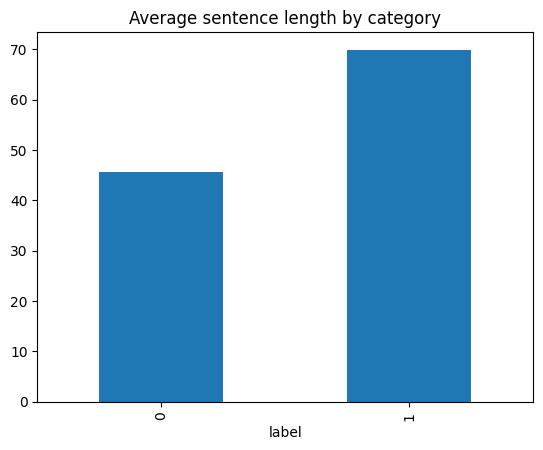

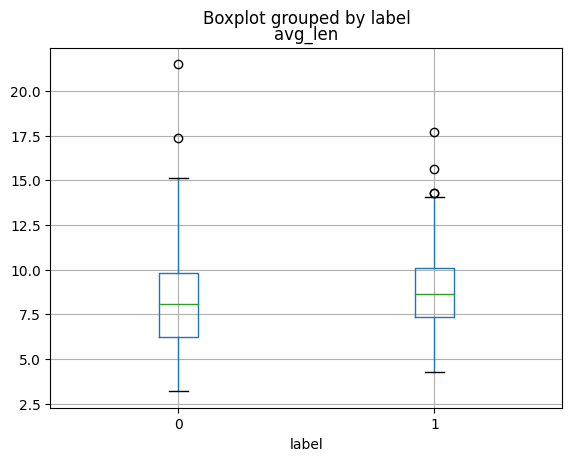

In [115]:
def avg_sentence_length(row):
    return sum(len(sublist) for sublist in row["norm"]) / len(row["norm"])

avg_sent = df1.groupby("label").apply(avg_sentence_length)
avg_sent.plot(kind='bar', title="Average sentence length by category")

df1["avg_sent_len"] = df1.apply(avg_sentence_length, axis=1)
df1.boxplot(by="label", column="avg_len")

### Min-Max sentence lengths

In [116]:
def min_sentence_length(row):
    return np.min([len(sublist) for sublist in row["norm"]])

def max_sentence_length(row):
    return np.max([len(sublist) for sublist in row["norm"]])

df1["min_sent_len"] = df1.apply(min_sentence_length, axis=1)
df1["max_sent_len"] = df1.apply(max_sentence_length, axis=1)

In [122]:
print("Minimum sentence length across all catageories", df1["min_sent_len"].min())
print("Minimum sentence length per category", df1.groupby("label")["min_sent_len"].min())

print("Maximum sentence length across all catageories", df1["max_sent_len"].max())
print("Maximum sentence length per category", df1.groupby("label")["max_sent_len"].max())

Minimum sentence length across all catageories 1
Minimum sentence length per category label
0    1
1    1
Name: min_sent_len, dtype: int64
Maximum sentence length across all catageories 88
Maximum sentence length per category label
0    88
1    84
Name: max_sent_len, dtype: int64


### Token occurences

In [21]:
# word freq by sentences
df1["counter"] = df1["norm"].apply(lambda x: [Counter(sublist) for sublist in x])

In [22]:
df1["counter_w_stops"] = df1["norm_with_stops"].apply(lambda x: [Counter(sublist) for sublist in x])

In [ ]:
sum((tuple(sum(df1[df1["label"]==0]["counter"], []))), Counter())

In [167]:
# unroll each sentence into a row
df_count = df1[["counter", "label"]].explode("counter")

In [172]:
# Set index based on article, assigning a number to each sentence 
df_count['sent_nb'] = df_count.groupby(['label']).cumcount()+1

In [173]:
df_count

,counter,label,sent_nb
0,"{'knud': 1, 'agger': 1, '26': 1, 'september': ...",1,1
0,"{'series': 1, 'paintings': 1, 'everyday': 1, '...",1,2
0,"{'time': 1, 'work': 1, 'took': 1, 'visionary':...",1,3
0,"{'biography': 1, 'knud': 1, 'agger': 1, 'origi...",1,4
0,"{'returned': 1, 'native': 1, 'region': 1, '192...",1,5
...,...,...,...
666,{'httpnbnresolvingdeurnnbndehbz688239662183': 1},1,14253
666,"{'rachel': 1, 'dickson': 1, 'adler': 1, 'centu...",1,14254
666,"{'references': 1, 'external': 1, 'links': 1, '...",1,14255
666,"{'retrieved': 1, 'september': 1, '2016': 1}",1,14256


#### Min/max/avg number of token occurrences per sentence per category.

In [175]:
df_count["avg_tok_occ"] = df_count["counter"].apply(lambda x: np.mean(list(x.values())))
df_count["min_tok_occ"] = df_count["counter"].apply(lambda x: np.min(list(x.values())))
df_count["max_tok_occ"] = df_count["counter"].apply(lambda x: np.max(list(x.values())))

In [176]:
df_count

,counter,label,sent_nb,avg_tok_occ,min_tok_occ,max_tok_occ
0,"{'knud': 1, 'agger': 1, '26': 1, 'september': ...",1,1,1.0000,1,1
0,"{'series': 1, 'paintings': 1, 'everyday': 1, '...",1,2,1.0000,1,1
0,"{'time': 1, 'work': 1, 'took': 1, 'visionary':...",1,3,1.0000,1,1
0,"{'biography': 1, 'knud': 1, 'agger': 1, 'origi...",1,4,1.0625,1,2
0,"{'returned': 1, 'native': 1, 'region': 1, '192...",1,5,1.0000,1,1
...,...,...,...,...,...,...
666,{'httpnbnresolvingdeurnnbndehbz688239662183': 1},1,14253,1.0000,1,1
666,"{'rachel': 1, 'dickson': 1, 'adler': 1, 'centu...",1,14254,1.0000,1,1
666,"{'references': 1, 'external': 1, 'links': 1, '...",1,14255,1.0000,1,1
666,"{'retrieved': 1, 'september': 1, '2016': 1}",1,14256,1.0000,1,1


#### Total number of tokens by category 


In [53]:
# Total number of tokens by category 
df1


,text,label,nlp,sents,norm,norm_no_stops,norm_with_stops,counter,counter_w_stops
0,Knud Agger (26 September 1895 – 2 February 197...,1,"(Knud, Agger, (, 26, September, 1895, –, 2, Fe...","[[Knud, Agger, (, 26, September, 1895, –, 2, F...","[[knud, agger, 26, september, 1895, 2, februar...","[[knud, agger, , 26, september, 1895, –, 2, fe...","[[knud, agger, 26, september, 1895, 2, februar...","[{'knud': 1, 'agger': 1, '26': 1, 'september':...","[{'knud': 1, 'agger': 1, '': 4, '26': 1, 'sept..."
1,Milton Abramowitz (19 February 1915 in Brookly...,0,"(Milton, Abramowitz, (, 19, February, 1915, in...","[[Milton, Abramowitz, (, 19, February, 1915, i...","[[milton, abramowitz, 19, february, 1915, broo...","[[milton, abramowitz, , 19, february, 1915, br...","[[milton, abramowitz, 19, february, 1915, in, ...","[{'milton': 1, 'abramowitz': 2, '19': 1, 'febr...","[{'milton': 1, 'abramowitz': 2, '': 7, '19': 1..."
2,Akram Aldroubi is an American mathematician kn...,0,"(Akram, Aldroubi, is, an, American, mathematic...","[[Akram, Aldroubi, is, an, American, mathemati...","[[akram, aldroubi, american, mathematician, kn...","[[akram, aldroubi, american, mathematician, kn...","[[akram, aldroubi, is, an, american, mathemati...","[{'akram': 1, 'aldroubi': 1, 'american': 1, 'm...","[{'akram': 1, 'aldroubi': 1, 'is': 1, 'an': 1,..."
3,Hans Asper (c. 1499 – 21 March 1571) was a Swi...,1,"(Hans, Asper, (, c., 1499, –, 21, March, 1571,...","[[Hans, Asper, (, c., 1499, –, 21, March, 1571...","[[hans, asper, c, 1499, 21, march, 1571, swiss...","[[hans, asper, , c, 1499, –, 21, march, 1571, ...","[[hans, asper, c, 1499, 21, march, 1571, was, ...","[{'hans': 1, 'asper': 1, 'c': 1, '1499': 1, '2...","[{'hans': 1, 'asper': 1, '': 3, 'c': 1, '1499'..."
4,"Attila Aşkar (born September 4, 1943) is a Tur...",0,"(Attila, Aşkar, (, born, September, 4, ,, 1943...","[[Attila, Aşkar, (, born, September, 4, ,, 194...","[[attila, born, september, 4, 1943, turkish, c...","[[attila, aşkar, , born, september, 4, , 1943,...","[[attila, born, september, 4, 1943, is, a, tur...","[{'attila': 1, 'born': 1, 'september': 1, '4':...","[{'attila': 1, 'aşkar': 1, '': 7, 'born': 1, '..."
...,...,...,...,...,...,...,...,...,...
662,Adalbold II of Utrecht (died 27 November 1026)...,0,"(Adalbold, II, of, Utrecht, (, died, 27, Novem...","[[Adalbold, II, of, Utrecht], [(, died, 27, No...","[[adalbold, ii, utrecht], [died, 27, november,...","[[adalbold, ii, utrecht], [, died, 27, novembe...","[[adalbold, ii, of, utrecht], [died, 27, novem...","[{'adalbold': 1, 'ii': 1, 'utrecht': 1}, {'die...","[{'adalbold': 1, 'ii': 1, 'of': 1, 'utrecht': ..."
663,Richard Alejandro Arratia is a mathematician n...,0,"(Richard, Alejandro, Arratia, is, a, mathemati...","[[Richard, Alejandro, Arratia, is, a, mathemat...","[[richard, alejandro, arratia, mathematician, ...","[[richard, alejandro, arratia, mathematician, ...","[[richard, alejandro, arratia, is, a, mathemat...","[{'richard': 1, 'alejandro': 1, 'arratia': 1, ...","[{'richard': 1, 'alejandro': 1, 'arratia': 1, ..."
664,Phoebe Sarah Hertha Ayrton (28 April 1854 – 26...,0,"(Phoebe, Sarah, Hertha, Ayrton, (, 28, April, ...","[[Phoebe, Sarah, Hertha, Ayrton, (, 28, April,...","[[phoebe, sarah, hertha, ayrton, 28, april, 18...","[[phoebe, sarah, hertha, ayrton, , 28, april, ...","[[phoebe, sarah, hertha, ayrton, 28, april, 18...","[{'phoebe': 1, 'sarah': 1, 'hertha': 1, 'ayrto...","[{'phoebe': 1, 'sarah': 1, 'hertha': 1, 'ayrto..."
665,René Victor Auberjonois (18 August 1872 – 11 O...,1,"(René, Victor, Auberjonois, (, 18, August, 187...","[[René, Victor, Auberjonois, (, 18, August, 18...","[[victor, auberjonois, 18, august, 1872, 11, o...","[[rené, victor, auberjonois, , 18, august, 187...","[[victor, auberjonois, 18, august, 1872, 11, o...","[{'victor': 1, 'auberjonois': 1, '18': 1, 'aug...","[{'rené': 1, 'victor': 1, 'auberjonois': 1, ''..."


### Most common tokens by category

In [26]:
# Token occurence per category
mathematicians = sum((tuple(sum(df1[df1["label"]==0]["counter"], []))), Counter())
painters = sum((tuple(sum(df1[df1["label"]==1]["counter"], []))), Counter())

In [43]:
mathematicians_wstop = sum((tuple(sum(df1[df1["label"]==0]["counter_w_stops"], []))), Counter())
painters_wstop = sum((tuple(sum(df1[df1["label"]==1]["counter_w_stops"], []))), Counter())

In [27]:
print("Most common tokens for mathematician category :", mathematicians.most_common(10))
print("Most common tokens for painter category :", painters.most_common(10))

Most common tokens for mathematician category : [('university', 1791), ('mathematics', 1437), ('mathematical', 846), ('theory', 731), ('work', 566), ('professor', 549), ('society', 492), ('research', 473), ('american', 462), ('de', 462)]
Most common tokens for painter category : [('art', 1603), ('painting', 704), ('work', 628), ('works', 593), ('new', 588), ('paintings', 573), ('artists', 556), ('museum', 465), ('gallery', 396), ('painter', 366)]


<BarContainer object of 10 artists>

) missing from current font.dscourse/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.dscourse/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


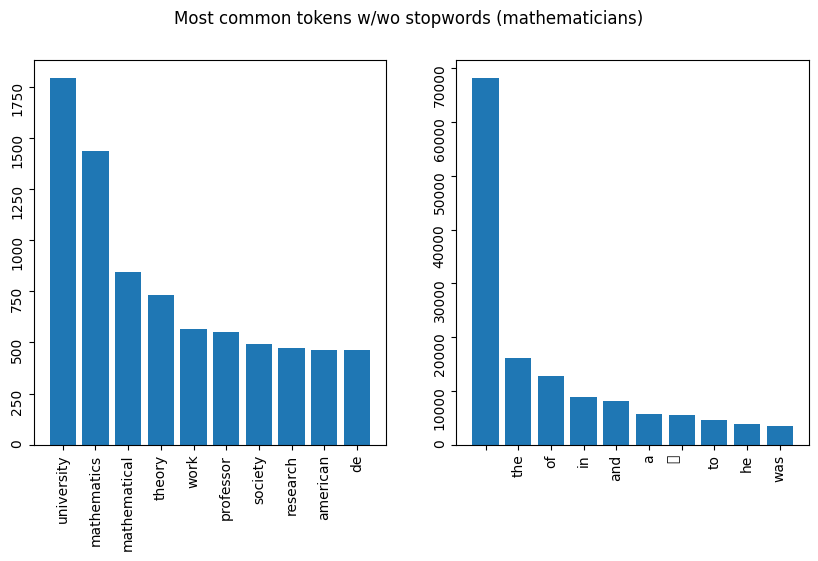

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common tokens w/wo stopwords (mathematicians)')
ax1.bar(*zip(*mathematicians.most_common(10)))
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*mathematicians_wstop.most_common(10)))

<BarContainer object of 10 artists>

) missing from current font.dscourse/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.dscourse/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


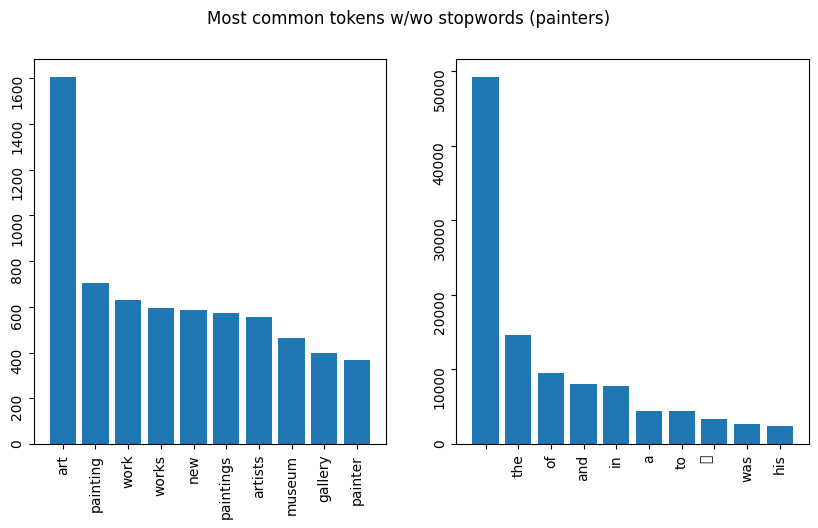

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common tokens w/wo stopwords (painters)')
ax1.bar(*zip(*painters.most_common(10)))
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*painters_wstop.most_common(10)))

### 50 Most common words 

In [50]:
print("Most common 50 words (mathematicians) :")
print("With stopwords :")
print(mathematicians_wstop.most_common(50))
print("Without stopwords :")
print(mathematicians.most_common(50))

Most common 50 words (mathematicians) :
With stopwords :
[('', 68168), ('the', 16044), ('of', 12826), ('in', 8893), ('and', 8186), ('a', 5755), ('\r\n', 5549), ('to', 4624), ('he', 3772), ('was', 3488), ('his', 2527), ('at', 2423), ('\r\n\r\n\r\n', 2361), ('for', 2203), ('on', 2200), ('as', 1937), ('is', 1861), ('s', 1812), ('university', 1791), ('with', 1624), ('from', 1581), ('by', 1535), ('that', 1461), ('mathematics', 1437), ('an', 1274), (' ', 971), ('mathematical', 846), ('which', 750), ('also', 741), ('theory', 731), ('this', 688), ('it', 676), ('–', 625), ('she', 570), ('work', 566), ('professor', 549), ('had', 544), ('first', 541), ('one', 498), ('society', 492), ('be', 492), ('research', 473), ('her', 469), ('are', 468), ('american', 462), ('de', 462), ('references', 460), ('new', 455), ('mathematician', 452), ('science', 450)]
Without stopwords :
[('university', 1791), ('mathematics', 1437), ('mathematical', 846), ('theory', 731), ('work', 566), ('professor', 549), ('society

In [51]:
print("Most common 50 words (painters) :")
print("With stopwords :")
print(painters_wstop.most_common(50))
print("Without stopwords :")
print(painters.most_common(50))

Most common 50 words (painters) :
With stopwords :
[('', 49192), ('the', 14671), ('of', 9529), ('and', 8080), ('in', 7822), ('a', 4378), ('to', 4376), ('\r\n', 3376), ('was', 2637), ('his', 2414), ('as', 2155), ('he', 2127), ('by', 1680), ('with', 1643), ('art', 1603), ('at', 1594), ('s', 1572), ('for', 1534), ('\r\n\r\n\r\n', 1446), ('on', 1358), ('is', 1285), ('from', 1251), ('that', 1219), ('an', 1008), ('were', 860), ('also', 751), ('which', 727), ('painting', 704), ('it', 680), ('or', 665), ('work', 628), ('are', 625), ('her', 610), ('this', 600), ('works', 593), ('new', 588), ('paintings', 573), ('had', 563), ('\r\n\r\n', 559), ('artists', 556), ('be', 534), (' ', 514), ('their', 513), ('she', 476), ('who', 466), ('museum', 465), ('first', 457), ('but', 430), ('other', 428), ('such', 427)]
Without stopwords :
[('art', 1603), ('painting', 704), ('work', 628), ('works', 593), ('new', 588), ('paintings', 573), ('artists', 556), ('museum', 465), ('gallery', 396), ('painter', 366), ('

In [68]:
print("Number of tokens (with stop words and NO normalization) :", sum(df1["nlp"].apply(lambda x : len(x))))
print("Number of tokens (NO stop words and normalization) :", sum(df1["norm"].apply(lambda x : sum(len(s) for s in x))))
print("Number of tokens (NO stop words and normalization) :", sum(df1["norm_with_stops"].apply(lambda x : sum(len(s) for s in x))))

Number of tokens (with stop words and NO normalization) : 659282
Number of tokens (NO stop words and normalization) : 303968
Number of tokens (NO stop words and normalization) : 516747


In [72]:
math_norm_nostop_txt = " ".join(sum(df1[df1["label"]==0]["norm"].apply(lambda x : sum(x, [])), []))
math_norm_wstop_text = " ".join(sum(df1[df1["label"]==0]["norm_with_stops"].apply(lambda x : sum(x, [])), []))

In [73]:
paint_norm_nostop_txt = " ".join(sum(df1[df1["label"]==1]["norm"].apply(lambda x : sum(x, [])), []))
paint_norm_wstop_text = " ".join(sum(df1[df1["label"]==1]["norm_with_stops"].apply(lambda x : sum(x, [])), []))

### Wordcloud

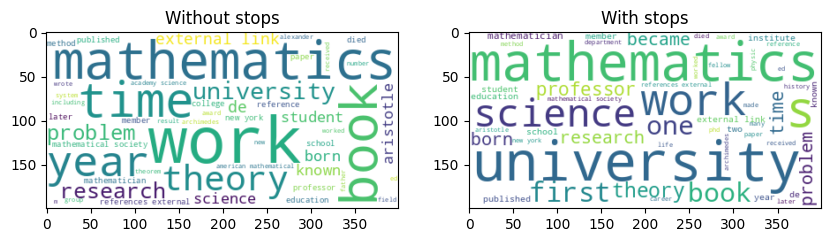

In [89]:
wc1 = WordCloud(background_color = 'white', stopwords = nlp.Defaults.stop_words, max_words = 50).generate(math_norm_nostop_txt)
wc2 = WordCloud(background_color = 'white', max_words = 50).generate(math_norm_wstop_text)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(wc1, interpolation="bilinear")
ax1.title.set_text('Without stops')
ax2.imshow(wc2, interpolation="bilinear")
ax2.title.set_text('With stops')

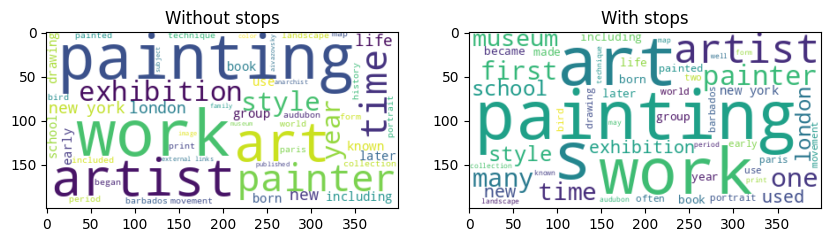

In [91]:
wc1 = WordCloud(background_color = 'white', max_words = 50).generate(paint_norm_nostop_txt)
wc2 = WordCloud(background_color = 'white', max_words = 50).generate(paint_norm_wstop_text)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(wc1, interpolation="bilinear")
ax1.title.set_text('Without stops')
ax2.imshow(wc2, interpolation="bilinear")
ax2.title.set_text('With stops')

### Unused

In [133]:
# max-min-avg
df_count["mini"] = df_count['counter'].apply(lambda x: min(x.values()))
df_count["maxi"] = df_count['counter'].apply(lambda x: max(x.values()))
df_count["most_common"] = df_count['counter'].apply(lambda x: Counter(x).most_common(1)[0][0])
df_count["least_common"] = df_count['counter'].apply(lambda x: Counter(x).most_common()[-1][0])

In [135]:
df_count

,counter,label,sent_nb,mini,maxi,most_common,least_common
0,"{'knud': 1, 'agger': 1, '26': 1, 'september': ...",1,1,1,1,knud,painter
0,"{'series': 1, 'paintings': 1, 'everyday': 1, '...",1,2,1,1,series,zealand
0,"{'time': 1, 'work': 1, 'took': 1, 'visionary':...",1,3,1,1,time,character
0,"{'biography': 1, 'knud': 1, 'agger': 1, 'origi...",1,4,1,2,architecture,arts
0,"{'returned': 1, 'native': 1, 'region': 1, '192...",1,5,1,1,returned,limfjorden
...,...,...,...,...,...,...,...
666,{'httpnbnresolvingdeurnnbndehbz688239662183': 1},1,14253,1,1,httpnbnresolvingdeurnnbndehbz688239662183,httpnbnresolvingdeurnnbndehbz688239662183
666,"{'rachel': 1, 'dickson': 1, 'adler': 1, 'centu...",1,14254,1,1,rachel,0900157660
666,"{'references': 1, 'external': 1, 'links': 1, '...",1,14255,1,1,references,museum
666,"{'retrieved': 1, 'september': 1, '2016': 1}",1,14256,1,1,retrieved,2016


In [203]:
df1["dist_freq"] = df1["counter"].apply(lambda x: list(sum(x, Counter()).values()))

/home/manil/miniconda3/envs/dscourse/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


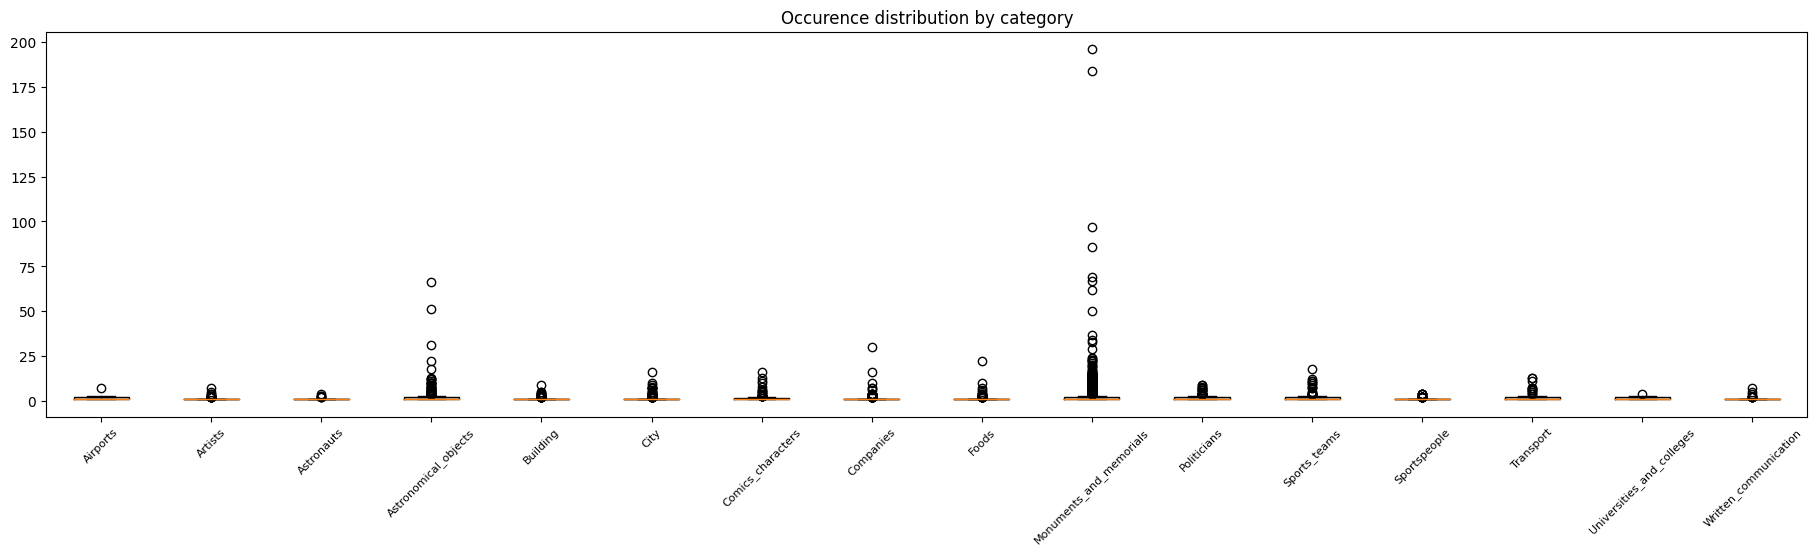

In [223]:

fig = plt.figure(figsize=(50,5))
ax = fig.add_subplot(121)

ax.set_title('Occurence distribution by category')
ax.set_xticklabels(df1["label"],
                    rotation=45, fontsize=8)
ax.boxplot(df1["dist_freq"].to_list())
plt.show()


In [19]:
df_count

,counter,label,sent_nb,mini,maxi,most_common,least_common
0,"{'cardiff': 2, 'roller': 2, 'collective': 1, '...",Airports,1,1,2,cardiff,wales
0,"{'founded': 1, '2010': 1, 'league': 1, 'roller...",Airports,2,1,2,roller,group
0,"{'founded': 1, 'october': 1, '2010': 1, 'initi...",Airports,3,1,1,founded,rearranged
0,"{'collective': 1, 'joined': 1, 'bridgend': 1, ...",Airports,4,1,1,collective,2009
0,"{'bombshells': 1, 'based': 1, 'bridgend': 1, '...",Airports,5,1,2,roller,people
...,...,...,...,...,...,...,...
15,"{'homer': 1, 'happy': 1, 'ghost': 1}",Written_communication,10,1,1,homer,ghost
15,{'timmy': 1},Written_communication,11,1,1,timmy,timmy
15,"{'timid': 1, 'ghost': 1, 'references': 1}",Written_communication,12,1,1,timid,references
15,"{'external': 1, 'links': 1, 'harvey': 1, 'ente...",Written_communication,13,1,1,external,entertainment


In [187]:
df_count["avg"] = df_count["counter"].apply(lambda x: np.mean(list(x.values())))

In [226]:
df_count

,counter,label,sent_nb,mini,maxi,most_common,least_common,avg
0,"{'cardiff': 2, 'roller': 2, 'collective': 1, '...",Airports,1,1,2,cardiff,wales,1.25
0,"{'founded': 1, '2010': 1, 'league': 1, 'roller...",Airports,2,1,2,roller,group,1.10
0,"{'founded': 1, 'october': 1, '2010': 1, 'initi...",Airports,3,1,1,founded,rearranged,1.00
0,"{'collective': 1, 'joined': 1, 'bridgend': 1, ...",Airports,4,1,1,collective,2009,1.00
0,"{'bombshells': 1, 'based': 1, 'bridgend': 1, '...",Airports,5,1,2,roller,people,1.04
...,...,...,...,...,...,...,...,...
15,"{'homer': 1, 'happy': 1, 'ghost': 1}",Written_communication,10,1,1,homer,ghost,1.00
15,{'timmy': 1},Written_communication,11,1,1,timmy,timmy,1.00
15,"{'timid': 1, 'ghost': 1, 'references': 1}",Written_communication,12,1,1,timid,references,1.00
15,"{'external': 1, 'links': 1, 'harvey': 1, 'ente...",Written_communication,13,1,1,external,entertainment,1.00


### Bonus

In [ ]:
# TODO: remove spaces and \n
# word frequency per category
# POS count per category
# NE count per category

### Most common postags per category

In [109]:
# Most common verb
def pos_tag(row):
    pos_count = []
    for sent in row.sents:
        c = Counter(token.pos_ for token in sent)
        pos_count.append(c)
    return sum(tuple(pos_count), Counter())

def named_entity(row):
    ne_count = []
    for sent in row.sents:
        c = Counter(token.pos_ for token in sent)
        ne_count.append(c)
    return sum(tuple(ne_count), Counter())

def ne_per_token(row, propn=True):
    ne_count = []
    for sent in row.sents:
        c = Counter((token.text, token.pos_) for token in sent if (not propn and token.pos_!= "PROPN") or propn)
        ne_count.append(c)
    return sum(tuple(ne_count), Counter())

In [93]:
df1["pos_tags"] = df1["nlp"].apply(pos_tag)
df1["ne"] = df1["nlp"].apply(named_entity)

In [111]:
df1["ne_token_npropn"] = df1["nlp"].apply(ne_per_token, propn=False)
df1["ne_token_propn"] = df1["nlp"].apply(ne_per_token)

In [97]:
math_pos = sum(df1[df1["label"]==0]["pos_tags"], Counter())
paint_pos = sum(df1[df1["label"]==1]["pos_tags"], Counter())

<BarContainer object of 10 artists>

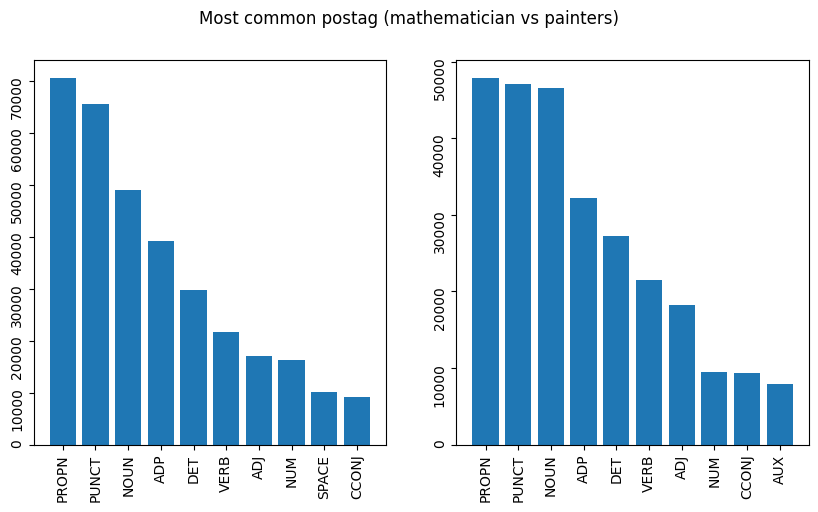

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common postag (mathematician vs painters)')
ax1.bar(*zip(*math_pos.most_common(10)))
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*paint_pos.most_common(10)))

In [ ]:
math_ne_token = sum(df1[df1["label"]==0]["pos_tags"], Counter())
paint_ne_token = sum(df1[df1["label"]==1]["pos_tags"], Counter())

### Most frequent words per category

In [ ]:
counts_dict = doc.count_by(spacy.attrs.IDS['POS'])

### Wordcloud per category

### Most common 50 words

In [ ]:
print("Number of sentences: ", len(list(doc.sents)))
print("Number of sentences: ", len(list(doc.sents)))

Number of sentences:  14
Number of sentences:  14
